Implementation an adaptation of blog post:  Lau, Benjamin.  ["Andrew Ng's Machine Learning Course in Python (Neural Networks)"](https://towardsdatascience.com/andrew-ngs-machine-learning-course-in-python-neural-networks-e526b41fdcd9) Towards Data Science.  27 December, 2018.  

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.io
from pathlib import Path

In [2]:
PATH = Path.home() / "Code/cipher813/coursera_ng_machine_learning/machine-learning-ex3/ex3/"

In [3]:
data = scipy.io.loadmat(PATH / "ex3data1.mat")

X = data["X"]
y = data["y"]

print(X.shape, y.shape)

(5000, 400) (5000, 1)


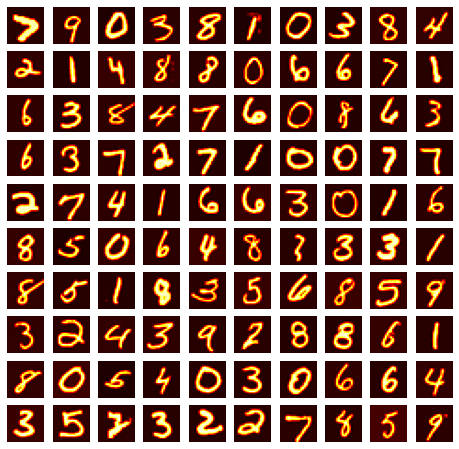

In [4]:
fig, axis = plt.subplots(10,10, figsize=(8,8))
for i in range(10):
    for j in range(10):
        
        axis[i,j].imshow(X[np.random.randint(0,5001),:].reshape(20,20,order="F"), cmap="hot")
        axis[i,j].axis("off")

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def lr_cost_function(theta, X, y, lmda):
    """takes in numpy arry of theta, X, y and float lambda to compute
    the regularized logistic cost function"""
    m = len(y)
    predictions = sigmoid(X @ theta)
    error = (-y * np.log(predictions)) - ((1-y)*np.log(1-predictions))
    cost = 1/m * sum(error)
    reg_cost = cost + lmda/(2*m) * sum(theta[1:]**2)
    
    # compute gradient
    j_0 = 1/m * (X.transpose() @ (predictions - y))[0]
    j_1 = 1/m * (X.transpose() @ (predictions - y))[1:] + (lmda/m)*theta[1:]
    grad = np.vstack((j_0[:,np.newaxis],j_1))
    return reg_cost[0], grad

In [6]:
theta_t = np.array([-2,-1,1,2]).reshape(4,1)
X_t = np.array([np.linspace(0.1,1.5,15)]).reshape(3,5).T
X_t = np.hstack((np.ones((5,1)), X_t))
y_t = np.array([1,0,1,0,1]).reshape(5,1)
J, grad = lr_cost_function(theta_t, X_t, y_t, 3)
print("Cost:",J,"Expected cost: 2.534819")
print("Gradients:\n",grad,"\nExpected gradients:\n 0.146561\n-0.548558\n 0.724722\n 1.398003")

Cost: 2.534819396109744 Expected cost: 2.534819
Gradients:
 [[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]] 
Expected gradients:
 0.146561
-0.548558
 0.724722
 1.398003


In [7]:
def gradient_descent(X, y, theta, alpha, num_iters, lmda):
    """Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration"""
    m = len(y)
    J_history = []
    
    for i in range(num_iters):
        cost, grad = lr_cost_function(theta, X, y, lmda)
        theta = theta - (alpha * grad)
        J_history.append(cost)
        
    return theta, J_history

def ova(X, y, num_labels, lmda):
    """Takes in numpy array of X, y, int num_labels and float lambda to train
    multiple logistic regression classifiers depending on the number of num_labels
    using gradient descent
    
    returns a matrix of theta, where the i-th row corresponds to the classifier for label i
    """
    m, n = X.shape
    initial_theta = np.zeros((n+1,1))
    all_theta = []
    all_J = []
    # add intercept terms
    X = np.hstack((np.ones((m,1)),X))
    
    for i in range(1, num_labels+1):
        theta, J_history = gradient_descent(X, np.where(y==i,1,0), initial_theta, 1, 300, lmda)
        all_theta.extend(theta)
        all_J.extend(J_history)
    return np.array(all_theta).reshape(num_labels, n+1), all_J

In [8]:
all_theta, all_J = ova(X, y, 10,1)

Text(0.5, 1.0, 'Cost function using Gradient Descent')

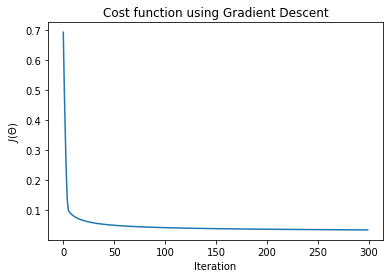

In [9]:
plt.plot(all_J[:300])
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

In [10]:
def predict_ova(all_theta, X):
    """Using all_theta, compute probability of X(i) for each class and predict the label
    
    Return a vector of prediction"""
    m = X.shape[0]
    X = np.hstack((np.ones((m,1)),X))
    
    predictions = X @ all_theta.T
    return np.argmax(predictions, axis=1)+1

pred = predict_ova(all_theta,X)
print("Training Set Accuracy", sum(pred[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy 91.42 %


In [11]:
# load optimized theta
weights = scipy.io.loadmat(PATH / "ex3weights.mat")
Theta1 = weights["Theta1"]  # size 25 x 401
Theta2 = weights["Theta2"]  # size 10 x 26

In [12]:
def predict(Theta1, Theta2, X):
    """Predict label of an input given a trained neural network"""
    m = X.shape[0]
    X = np.hstack((np.ones((m,1)),X))
    
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)),a1))  # hidden layer
    a2 = sigmoid(a1 @ Theta2.T)  # output layer
    
    return np.argmax(a2, axis=1) + 1

pred2 = predict(Theta1, Theta2, X)

In [15]:
print("Training Set Accuracy:", sum(pred2[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy: 97.52 %


In [17]:
def sigmoid_gradient(z):
    """computes gradient of sigmoid function"""
    sigmoid = 1/(1+np.exp(-z))
    return sigmoid * (1-sigmoid)

def nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda):
    """nn_params contains the params unrolled into a vector
    
    compute the cost and gradient of the neural network"""
    # reshape nn_params back into the params Theta1 and Theta2
    Theta1 = nn_params[:((input_layer_size+1)*hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[((input_layer_size+1)*hidden_layer_size):].reshape(num_labels,hidden_layer_size+1)
    
    m = X.shape[0]
    J=0
    X = np.hstack((np.ones((m,1)),X))
    y10 = np.zeros((m,num_labels))
    
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1))  # hidden layer
    a2 = sigmoid(a1 @ Theta2.T)  # output layer
    
    for i in range(1, num_labels+1):
        y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(a2[:,j]) - (1-y10[:,j])*np.log(1-a2[:,j]))
        
    cost = 1/m*J
    reg_J = cost + Lambda/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    
    # implement backpropagation algorithm to compute the gradients
    grad1 = np.zeros((Theta1.shape))
    grad2 = np.zeros((Theta2.shape))
    
    for i in range(m):
        xi = X[i,:]  # 1 x 401
        a1i = a1[i,:]  # 1 x 26
        a2i = a2[i,:]  # 1 x 10
        d2 = a2i - y10[i,:]
        d1 = Theta2.T @ d2.T * sigmoid_gradient(np.hstack((1,xi @ Theta1.T)))
        grad1 = grad1 + d1[1:][:,np.newaxis] @ xi[:,np.newaxis].T
        grad2 = grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T
        
    grad1 = 1/m * grad1
    grad2 = 1/m * grad2
    
    grad1_reg = grad1 + (Lambda/m) * np.hstack((np.zeros((Theta1.shape[0],1)), Theta1[:,1:]))
    grad2_reg = grad2 + (Lambda/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
    
    return cost, grad1, grad2, reg_J, grad1_reg, grad2_reg